In [17]:
import numpy as np
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from functions.read_g4bl_data import readDetData

# Location of g4bl output:
dir = 'g4bl-output/'

# Location to save animations:
fig_dir = 'animations/'

# Define RF period:
f = 325*10**6 # MHz
T = 1/f*10**9 # ns

# Number of detectors:
ndet = 31

In [18]:
# Choose to cut on total momentum:
cuts = True

# Define cuts (MeV/c):
low_p_cut = 0
high_p_cut = 400

In [19]:
### Define function to calculate emittance in one direction:
def calculate_emittance(position,momentum):
    covariance_matrix = np.cov(np.vstack((position, momentum)))
    emittance = np.sqrt(np.linalg.det(covariance_matrix))
    return emittance

### Define function to print ratios of initial to final emittances:
def emittance_ratios(emittances_x, emittances_y):
    # Ratio of initial to final x emittance:
    ex_initial = emittances_x[0]
    ex_final = emittances_x[len(emittances_x)-1]
    ex_ratio = ex_initial/ex_final
    print('Ratio of inital to final x emittance: '+str(ex_ratio))

    # Ratio of initial to final y emittance:
    ey_initial = emittances_y[0]
    ey_final = emittances_y[len(emittances_y)-1]
    ey_ratio = ey_initial/ey_final
    print('Ratio of inital to final y emittance: '+str(ey_ratio))

    # Ratio of initial to final total transverse emittance:
    transverse_e_ratio = ex_ratio * ey_ratio
    print('Ratio of initial to final total transverse emittance: '+str(transverse_e_ratio))

In [20]:
# Load data and calculate emittances:
x_vals = []; y_vals = []; z_vals = []
px_vals = []; py_vals = []; pz_vals = []; ptotal_vals = []
t_vals = []
eventIDs = []
kde_vals = []
emittances_x = []; emittances_y = []
for i in range(ndet):

    # Data from detectors:
    data = readDetData(dir+'out'+str(i+1)+'.txt', cuts=cuts, low_p_cut=low_p_cut, high_p_cut=high_p_cut)
    x_vals.append(data['x'].values); y_vals.append(data['y'].values); z_vals.append(data['z'].values) # mm
    px_vals.append(data['px'].values); py_vals.append(data['py'].values); pz_vals.append(data['pz'].values) # MeV/c
    ptotal_vals.append(data['ptotal'].values) # MeV/c
    t_vals.append(data['t'].values) # ns
    eventIDs.append(data['EventID'].values)

    # 2D Gaussian kernel density estimate:
    data_x_y = np.vstack([data['x'].values,data['y'].values])
    kde = gaussian_kde(data_x_y)
    kde_vals.append(kde(data_x_y))
    del data_x_y, kde

    # Emittances:
    emittance_x = calculate_emittance(data['x'].values,data['px'].values)
    emittance_y = calculate_emittance(data['y'].values,data['py'].values)
    emittances_x.append(emittance_x)
    emittances_y.append(emittance_y)
    del emittance_x, emittance_y

    del data

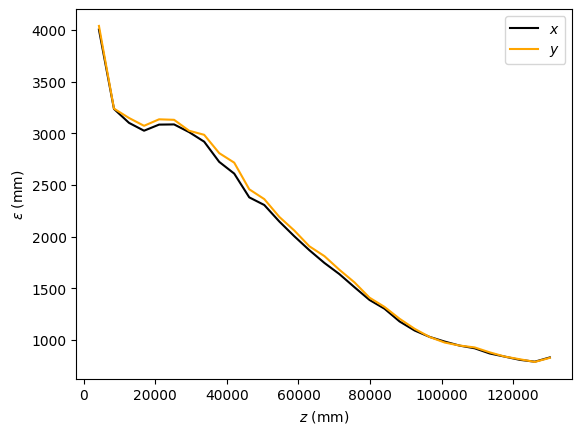

In [21]:
# Plot transverse emittance along channel:
plt.figure(1)
plt.plot([i[0] for i in z_vals],emittances_x,color='black',label='$x$')
plt.plot([i[0] for i in z_vals],emittances_y,color='orange',label='$y$')
plt.xlabel('$z$ (mm)')
plt.ylabel('$\epsilon$ (mm)')
plt.legend()
plt.show()

In [22]:
emittance_ratios(emittances_x, emittances_y)

Ratio of inital to final x emittance: 4.8266535727393896
Ratio of inital to final y emittance: 4.893093040427018
Ratio of initial to final total transverse emittance: 23.617265005323308


### With only surviving particles

In [23]:
# Find IDs of particles which survived to end of channel:
survivedIDs = eventIDs[len(eventIDs)-1]

# Limit data to only surviving particles:
x_vals_limited = []; y_vals_limited = []; z_vals_limited = []
px_vals_limited = []; py_vals_limited = []; pz_vals_limited = []
t_vals_limited = []
emittances_x_limited = []; emittances_y_limited = []
for i in range(ndet):

    # Data from detectors:
    x_limited = []; y_limited = []; z_limited = []
    px_limited = []; py_limited = []; pz_limited = []
    t_limited = []
    for j in range(len(x_vals[i])):
        if eventIDs[i][j] in survivedIDs:
            x_limited.append(x_vals[i][j])
            y_limited.append(y_vals[i][j])
            z_limited.append(z_vals[i][j])
            px_limited.append(px_vals[i][j])
            py_limited.append(py_vals[i][j])
            pz_limited.append(pz_vals[i][j])
            t_limited.append(t_vals[i][j])

    x_vals_limited.append(x_limited)
    y_vals_limited.append(y_limited)
    z_vals_limited.append(z_limited)
    px_vals_limited.append(px_limited)
    py_vals_limited.append(py_limited)
    pz_vals_limited.append(pz_limited)
    t_vals_limited.append(t_limited)

    # Emittances:
    emittance_x = calculate_emittance(x_limited,px_limited)
    emittance_y = calculate_emittance(y_limited,py_limited)
    emittances_x_limited.append(emittance_x)
    emittances_y_limited.append(emittance_y)
    del emittance_x, emittance_y

    del x_limited, px_limited, y_limited, py_limited

In [24]:
emittance_ratios(emittances_x_limited, emittances_y_limited)

Ratio of inital to final x emittance: 2.815235839342359
Ratio of inital to final y emittance: 2.9158569832160826
Ratio of initial to final total transverse emittance: 8.208825081546607


In [25]:
max_kde_vals = []
for i in range(31):
    max_kde_vals.append(max(kde_vals[i]))
max_kde = max(max_kde_vals)
print(max_kde)

0.000110651117521984


In [26]:
# # Animated contour plot:
# fig = plt.figure()
# def animate(frame):
#     plt.clf()
#     im = plt.tricontour(x_vals[frame],y_vals[frame],kde_vals[frame])
#     norm = Normalize(vmin=0,vmax=max_kde)
#     mapp = cm.ScalarMappable(norm=norm)
#     cbar = plt.colorbar(mapp)
#     im.set_clim(0,max_kde)
#     cbar.update_normal(im)
#     cbar.set_ticks(np.linspace(0,max_kde,num=6))
#     plt.xlim(-30,30)
#     plt.ylim(-30,30)
#     plt.xlabel('x (mm)')
#     plt.ylabel('y (mm)')
#     plt.title('z = '+str(round(position[frame]))+' mm, N = '+str(len(x_vals[frame])))
#     plt.grid()
# animation = FuncAnimation(fig, animate, frames=31, interval=400, repeat=True)
# animation.save(fig_dir+'contour_animation.gif', writer='pillow')

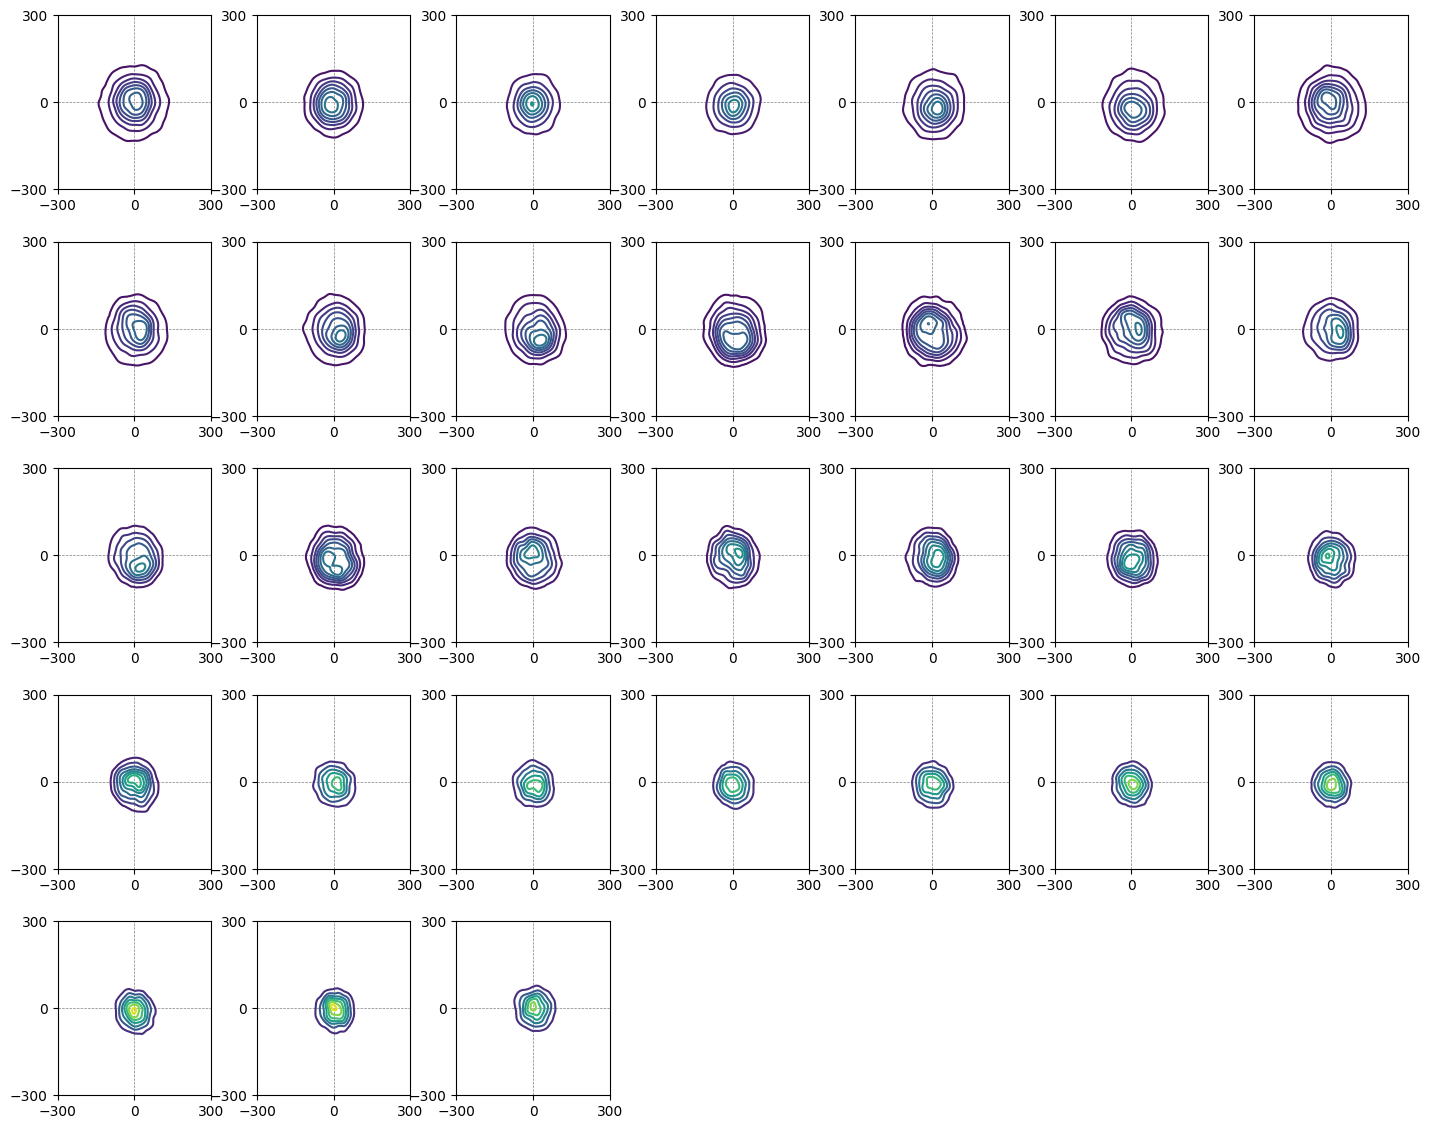

In [27]:
# Subplot of contours:
fig, axes = plt.subplots(5,7,figsize=(15,12))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)
axes = axes.flatten()
for i in range(31):
    ax = axes[i]
    im = ax.tricontour(x_vals[i],y_vals[i],kde_vals[i],cmap='viridis')
    im.set_clim(0,max_kde)
    ax.set_xlim(-300,300)
    ax.set_ylim(-300,300)
    ax.set_xticks(np.linspace(-300,300,num=3))
    ax.set_yticks(np.linspace(-300,300,num=3))
    # ax.set_title('z = '+str(round(z_vals[i][0]))+' mm, N = '+str(len(x_vals[i])))
    ax.grid(True,which='both',linestyle='--',color='gray',linewidth=0.5)
for i in range(31, 35):
    axes[i].axis('off')
plt.show()